In [ ]:
# Import all the libraries needed

%matplotlib inline

!pip install geopy
!pip install folium
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install scipy
!pip3 install lxml
!pip install geojson
!pip install xlrd
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
import folium.features
import json # library to handle JSON files
import geojson

from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Is there any correlation between Average Income in a borough and the levels of childhood obesity?

### Lets get some data

First we will need some economic data about the average income for each London borough. I got the data from https://data.london.gov.uk/dataset/earnings-place-residence-borough . This file contains the weekly average income per borough from the years 2002 to 2019. We are only interested in the most recent data, the 2019 data.

In [20]:
# I download the data file as a xlsx file and put it in local storage.

income = pd.read_excel("earnings-residence-borough.xlsx",sheet_name="Total, weekly") # Load file into 'income' dataframe
income.head()                                                                        # Show the first 5 rows of 'income'

,Code,Area,2002,Unnamed: 3,2003,Unnamed: 5,2004,Unnamed: 7,2005,Unnamed: 9,2006,Unnamed: 11,2007,Unnamed: 13,2008,Unnamed: 15,2009,Unnamed: 17,2010,Unnamed: 19,2011,Unnamed: 21,2012,Unnamed: 23,2013,Unnamed: 25,2014,Unnamed: 27,2015,Unnamed: 29,2016,Unnamed: 31,2017,Unnamed: 33,2018,Unnamed: 35,2019,Unnamed: 37
0,NaN,NaN,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %,Pay (£),conf %
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00AA,City of London,!,!,!,!,#,#,#,#,#,#,#,#,#,#,762.4,16,#,#,#,#,#,#,#,#,#,#,#,#,#,#,#,#,901.6,19,#,#
3,00AB,Barking and Dagenham,383.3,5.5,354.9,6.5,360.1,5.2,375.1,5.1,417.6,6,446.7,6.4,449.9,6.5,448.8,6.8,429.3,5.6,452.1,5.3,450,6.2,441.2,6.2,422.5,4.9,436.6,5.4,462.2,4.5,461,5.1,479.1,4.9,472.9,6.2
4,00AC,Barnet,427.4,5.1,450.1,5,453.3,5.6,442.3,5.3,466.1,5.7,460,5.6,502.2,5,528.1,5.5,501.6,5.7,498.3,4.9,503.1,5.1,517.5,4.4,479.1,4,491,4.9,485.6,5.4,522.6,4.5,536.6,4.8,536.6,4.4


As you can see the data contains a lot of junk, lets clean up the data. We only need the columns 'Area', which contains the name of the boroughs and '2019', which contains the avarage weekly income.

In [21]:
# Make a new dataframe called income which will hold the cleaned data

income = income[["Area",2019]]                                                  # We only need the Area and 2019 columns
income.rename(columns={'Area':"Borough",2019:"Average weekly pay"},inplace=True)# Rename the columns to better names
income = income[income["Average weekly pay"].notnull()]                         # Remove any rows that have null income 
income=income[2:34]                                                             # These are the rows which contain London data 
income.reset_index(drop=True, inplace=True)                                     # Reset the index.

display(income.head())                                                          # Show the first 5 rows of income
print("'income' dataframe contains",income.shape[0],"rows/boroughs")            # Verify the number of rows

,Borough,Average weekly pay
0,Barking and Dagenham,472.9
1,Barnet,536.6
2,Bexley,550.2
3,Brent,524.6
4,Bromley,641.3


'income' dataframe contains 32 rows/boroughs


As you can see we've got all 32 London Boroughs and the data is in a usable form now.

---

### Now lets get the childhood obesity data.

I got the childhood obesity data from https://www.trustforlondon.org.uk/data/child-obesity/ I downloaded a csv of the data on to my local storage for convience.
Lets have a look at the uncleaned data

In [66]:
obesity = pd.read_csv("Childhood obesity for children in Year 6 by London borough (2008_09 and 2018_19) .csv")
obesity.head()

,Area,ONS-code,Proportion of obese children in Year 6 (2008/09),Proportion of obese children in Year 6 (2018/19),Percentage points change between 2008/09 and 2018/19
0,England,E92000001,18.30%,20.20%,1.90%
1,London,E12000007,21.30%,23.20%,1.90%
2,Barking and Dagenham,E09000002,24.10%,29.60%,5.50%
3,Barnet,E09000003,18.30%,19.30%,1%
4,Bexley,E09000004,21.50%,22.70%,1.20%


Now I will clean the data. We are only inetested in the 'Area' and 'Proportion of obese children in Year 6 (2018/19)' columns.

In [67]:
obesity.drop(obesity.index[[0,1]],inplace=True)          # remove the first 2 rows as they are not data we need
obesity = obesity[obesity["ONS-code"].notnull()]         # remove any rows that do not have a ONS-code, rows which are not data
obesity = obesity[["Area","Proportion of obese children in Year 6 (2018/19)"]] # get the columns we need
# rename columns for convenience
obesity.rename(columns={"Area":"Borough","Proportion of obese children in Year 6 (2018/19)":"Proportion obese"},inplace=True)
obesity.reset_index(drop=True, inplace=True)                                     # reset the index
obesity["Proportion obese"] = obesity["Proportion obese"].str.replace("%", '').astype(float) # remove the % symbol from data
obesity["Proportion obese"]=obesity["Proportion obese"].astype(float)
display(obesity.head())                                                      # Display the first 5 rows of 'obese' data frame
print("'obesity' dataframe contains",obesity.shape[0],"rows/boroughs")       # Check that we have all 32 london boroughs

,Borough,Proportion obese
0,Barking and Dagenham,29.6
1,Barnet,19.3
2,Bexley,22.7
3,Brent,26.0
4,Bromley,17.1


'obesity' dataframe contains 32 rows/boroughs


As you can see we've got all 32 London Boroughs and the data is in a usable form now.

---

Now I will merge the 'income' and 'obesity' dataframes into a new dataframe called 'lon_in_ob'

In [68]:
lon_in_ob = pd.merge(obesity,income, on="Borough")  # Merge 'income' and 'obesity' on the key column 'Borough'
display(lon_in_ob.head())
print("The 'lon_in_ob' dataframe contains",lon_in_ob.shape[0],"rows/boroughs")  # Verify that we have all 32 boroughs

,Borough,Proportion obese,Average weekly pay
0,Barking and Dagenham,29.6,472.9
1,Barnet,19.3,536.6
2,Bexley,22.7,550.2
3,Brent,26.0,524.6
4,Bromley,17.1,641.3


The 'lon_in_ob' dataframe contains 32 rows/boroughs


## Now lets analyse this data.

I will use a scatter plot to see if there is any correlation between the average weekly pay in a borough and the level of child obesity in the borough

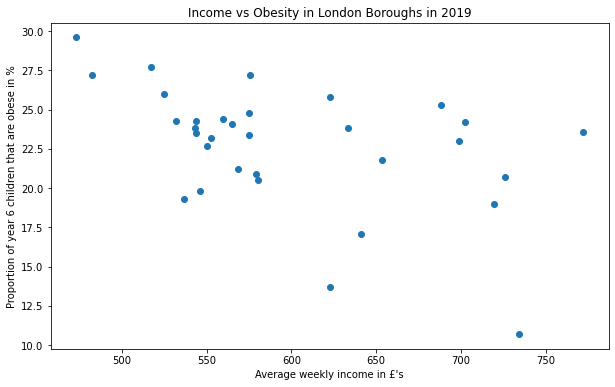

In [54]:
plt.figure(figsize=(10,6))
plt.scatter(lon_in_ob["Average weekly pay"], lon_in_ob["Proportion obese"], marker='o')
plt.xlabel("Average weekly income in £"+"'s")
plt.ylabel("Proportion of year 6 children that are obese in %")
plt.title("Income vs Obesity in London Boroughs in 2019")

plt.show()

TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

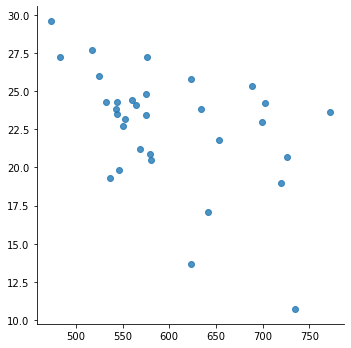

In [69]:
import seaborn as sns
sns.lmplot(x="Average weekly pay", y="Proportion obese", data=lon_in_ob)

Firstly lets get a geoJSON file for the greater London the London borough boundries from https://joshuaboyd1.carto.com/tables/london_boroughs_proper/public